# How to use the SSA for cell-cycle model

In this notebook we show how to use the SSA for the delayed telegraph to produce Monte Carlo trajectories and histograms.

The model is made up of 7 parameters:
- $\rho$, the rate at which the (on) gene produces nascent RNA (nRNA).
- $\sigma_{on}$, the rate at which the gene switches on.
- $\sigma_{off}$, the rate at which the gene switches off.
- $\tau$, the fixed time it takes for the nRNA to complete transcription (and fall off the DNA).
- $\kappa$, the gene dosage complensation, a fraction $\in [0,1]$ that scales $\rho$ after gene replication.
- $k$, the rate at which exponentially distributed periods of the cell cycle pass.
- $N$, the number of exponentially distributed cell cycle stages.

Note that in the simulation code we account for the nRNA produced by the mother and daughter gene separately, and at cell division follow one of these gene copies with probability 1/2. The gene is replicated at cell cycle stage `floor(Int,N/2)` (half way through, rounded down for odd $N$). The new daughter cell then has one gene copy, whose initial state and number of nRNA present are inherited from the previous cycle.

## Usage

In [1]:
include("./Stoch-sims-cell-cycle.jl"); using .SSAcellcycle;

Import some necessary packages for plotting and saving data.

In [2]:
using Plots, DelimitedFiles, LaTeXStrings, Distributions, Parameters, StatsBase, LinearAlgebra, Colors;
Plots.theme(:dao)

Now, let's define:
- `par_set`: the set of parameter for which we want to simulate in order $\{\rho,\sigma_{off},\sigma_{on}\,\kappa,k\}$.
- `τ`: the deterministic delay time of the transition from nascent to mature RNA.
- `N`: the number of exponentially distributed cell cycle stages.
- `total_time`: the total time of the simulation.
- `sp`: the sampling period of the SSA (how often the state vector is stored). Total number of data points stored will be $=$`total_time/sp`.
- `sims`: the number of independent Monte Carlo trajectories. If equal to 1 only a single SSA trajectory will be produced.

The initial conditions of the simulation are to start with the gene in the off state with zero $N$.

In [3]:
par_set = [2.11,0.609,0.0282,0.66,0.05]; # params should be float64.
τ = 150.0; # must be float64.
N = 10;
total_time = 1000000.0; # must be float64.
sp = 1.0; # must be float64.
sims = 1; # take a single trajectory. Must be integer.

In [4]:
# simulate
@time data=SSAdt(sims, par_set, τ, N, total_time, sp);

# take the individual trajectories of each species.
n_traj = data[2,1,:]+data[4,1,:]; 

# save the trajectory
writedlm(join([pwd(),"/test_data/cc_data_ipynb.csv"]),n_traj[1:end])

  1.030569 seconds (13.39 M allocations: 513.982 MiB, 28.10% gc time, 7.99% compilation time)


plt = Plot{Plots.GRBackend() n=1}


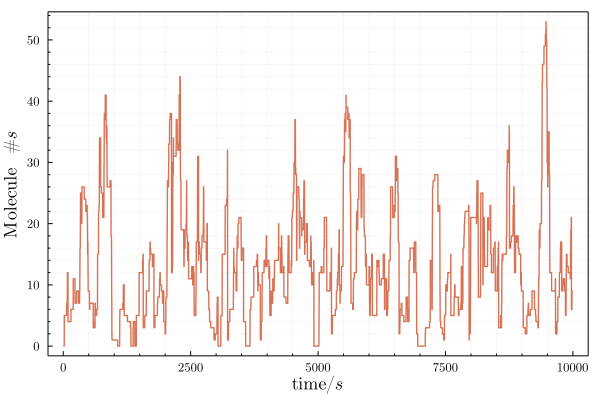

In [9]:
# plot first 1000 sample points
time = [sp*i for i in 1:10000];
plt = plot(time,n_traj[1:10000], label = L"$N$", legend = :none, grid = false);
xlabel!(L"\mathrm{time}/s"); ylabel!(L"\mathrm{Molecule}\quad \#s");
@show plt

Define a function to make the histograms.

In [6]:
function hist_prob(data::Vector{Float64})
        N = Int(floor(maximum(data)));
        mod_bins = LinRange(0.0,N,N);
        mid_pts = LinRange(0.0,N,N);
        bin_vals = normalize(fit(Histogram, data, mod_bins), mode=:probability).weights;
        return (mid_pts, bin_vals)
end

hist_prob (generic function with 1 method)

barplt = Plot{Plots.GRBackend() n=1}


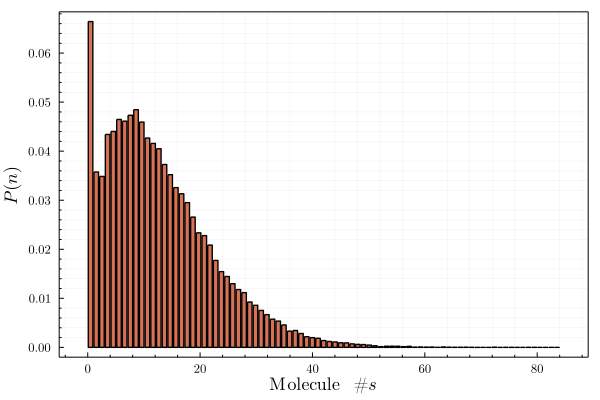

In [7]:
# plot historgram 
barplt = bar(hist_prob(n_traj[1000:end]), legend = :none, grid = false)
xlabel!(L"\mathrm{Molecule}\quad \#s"); ylabel!(L"P(n)");
@show barplt